In [2]:
import cv2
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# LOAD the datas

In [12]:
import os
import glob

base_path = '../../mocap_EMG_EEG_data/data_An_Yu/path1_07'
video_path = glob.glob(os.path.join(base_path, 'videos', '*.mp4'))[0]
trc_file_path = f'{base_path}/opensim/Empty_project_filt_0-30.trc'
trc_output_file_path = f'{base_path}/preprocessing/output/filtered_trc_file.trc'

cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("total frames: ", total_frames)
cap.release()

total frames:  990


# Find out the sync marker

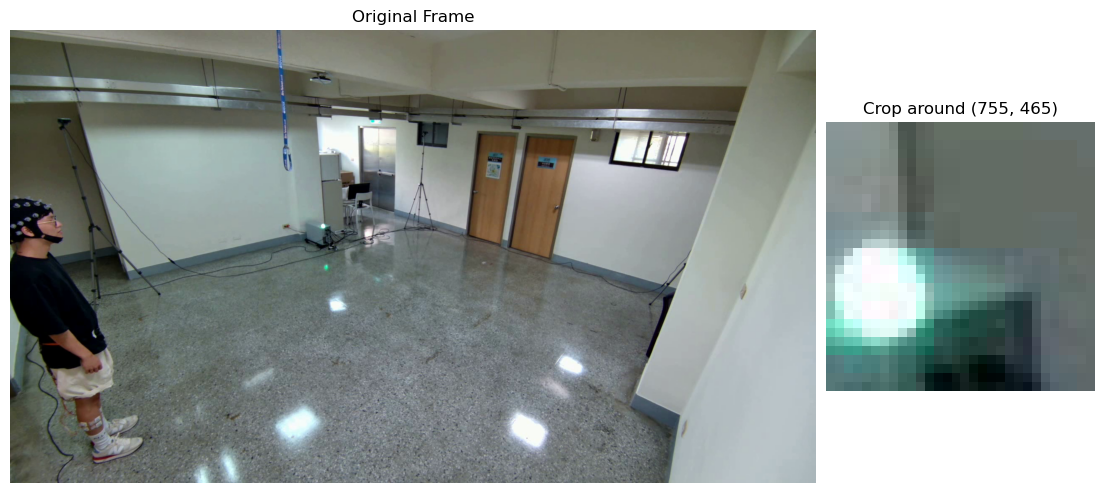

In [20]:
cap = cv2.VideoCapture(video_path)
frame_number = 500
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()
cap.release()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

lamp_x, lamp_y = 755, 465
half_size = 15
x_start = max(0, lamp_x - half_size)
x_end = min(frame.shape[1], lamp_x + half_size)
y_start = max(0, lamp_y - half_size)
y_end = min(frame.shape[0], lamp_y + half_size)
cropped_frame = frame[y_start:y_end, x_start:x_end]
cropped_frame_rgb = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [3, 1]})

axs[0].imshow(frame_rgb)
axs[0].set_title('Original Frame')
axs[0].axis('off')
axs[1].imshow(cropped_frame_rgb)
axs[1].set_title(f'Crop around ({lamp_x}, {lamp_y})')
axs[1].axis('off')
plt.subplots_adjust(wspace=0.02)
plt.show()

# the time of start blinking

In [17]:
brightness_values = []
cap = cv2.VideoCapture(video_path)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    brightness = gray_frame[lamp_y, lamp_x]
    brightness_values.append(brightness)

    frame_number += 1

cap.release()

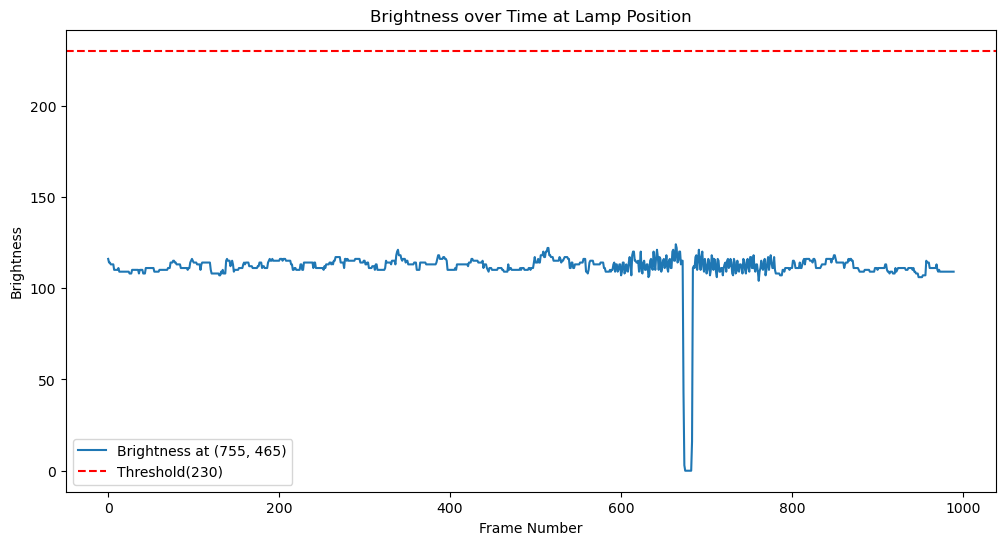

In [18]:
THRESHOLD = 230
plt.figure(figsize=(12, 6))
plt.plot(brightness_values, label=f'Brightness at ({lamp_x}, {lamp_y})')
plt.axhline(y=THRESHOLD, color='r', linestyle='--', label='Threshold(230)')  # 閾值線
plt.xlabel('Frame Number')
plt.ylabel('Brightness')
plt.title('Brightness over Time at Lamp Position')
plt.legend()
plt.show()

In [19]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(brightness_values, height=THRESHOLD)

if len(peaks) > 0:
    first_peak = peaks[0]
    print(f"first blink frame: {first_peak}")
else:
    print("None")

None


freq of blinking: 0.0 Hz


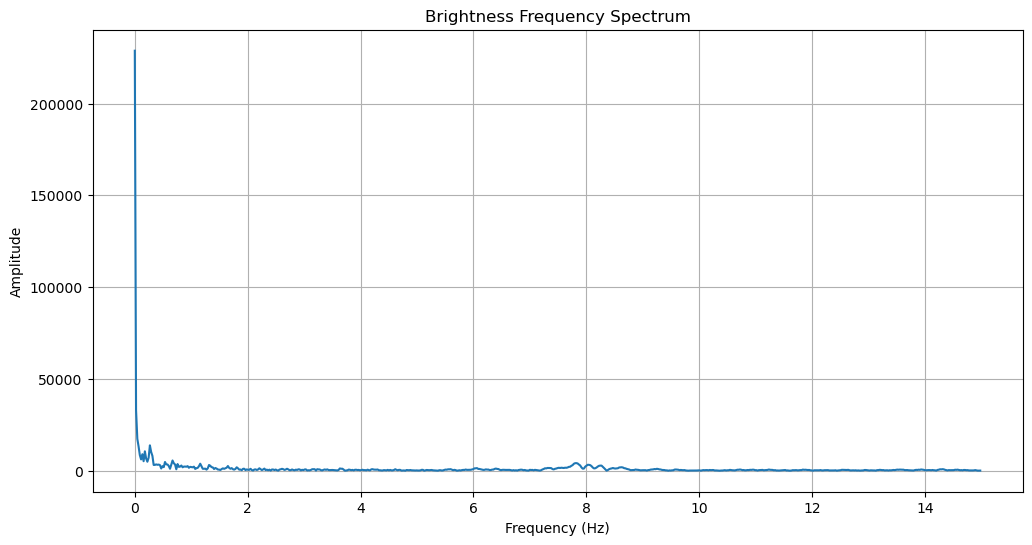

In [11]:
# Theoretically should blink in 16Hz
import numpy as np
from scipy.fft import fft, fftfreq

fps = 30.0
n = len(brightness_values)

brightness_fft = fft(brightness_values)
brightness_freq = fftfreq(n, 1/fps)

positive_freqs = brightness_freq[:n//2]
positive_fft = np.abs(brightness_fft[:n//2])

peak_freq = positive_freqs[np.argmax(positive_fft)]
print(f"freq of blinking: {peak_freq} Hz")

plt.figure(figsize=(12, 6))
plt.plot(positive_freqs, positive_fft)
plt.title('Brightness Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()
